### Skip gram without negative sampling

In [156]:
# Importing necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
import nltk
nltk.download('reuters')


[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [157]:
# Checking the version
np.__version__, torch.__version__, matplotlib.__version__, nltk.__version__

('2.1.2', '2.9.1+cu128', '3.10.7', '3.9.2')

In [158]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.9.1+cu128
True
NVIDIA GeForce RTX 5070 Laptop GPU


In [159]:
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize

### Word2vec Skip with Without Negative Sampling

In [160]:
# Create an empty list to store all Reuters news documents
documents = []

# Loop through each file ID available in the Reuters corpus
for fileid in reuters.fileids():
    
    # Read the full raw text of the current Reuters news file
    text = reuters.raw(fileid)
    
    # Append (store) the text of the document into the documents list
    documents.append(text)

In [161]:
corpus = corpus[:100]  # limit corpus size for faster training

In [162]:
# Get word sequences and extract unique words (vocabulary)

# Define a lambda function to flatten a list of lists into a single list
flatten = lambda l: [item for sublist in l for item in sublist]

# Flatten the corpus (list of documents) and extract unique words using set
vocab = list(set(flatten(corpus)))

# Display the first word in the vocabulary list
vocab[1]


'information'

In [163]:
#vocab size
voc_size = len(vocab)
print(voc_size)

2724


In [164]:
# Numericalization: convert words into numerical indices

# Create a dictionary that maps each word in the vocabulary to a unique integer index
word2index = {w: i for i, w in enumerate(vocab)}
word2index['lives'] # Get the index of the first word in the vocabulary


2458

In [165]:
# Append a special token for unknown (out-of-vocabulary) words
vocab.append('<UNK>')

In [166]:
#vocab size
voc_size = len(vocab)
print(voc_size)

2725


In [253]:
# Assign index 0 to the special <UNK> (unknown) token,
# so that all unseen or out-of-vocabulary words map to index 0
word2index['<UNK>'] = 0
index2word[0] = '<UNK>'


In [254]:
# Create a reverse mapping from index to word
# This dictionary allows us to convert numerical indices back into words
# It is useful for interpreting model outputs and debugging
index2word = {v: k for k, v in word2index.items()}

In [169]:
def random_batch(batch_size, word_sequence, window_size=2):
    """
    Generates a random batch of (target, context) pairs
    for Skip-gram model WITHOUT negative sampling.
    """
    
    # Create an empty list to store all (target, context) skip-gram pairs
    skip_grams = []
    
    # Loop through each sentence/document in the corpus
    for sent in corpus:
        
        # Iterate over each word position in the sentence
        for i in range(1,len(sent)-1):   # dynamic range, not fixed at edges
            
            # Get the index of the target (center) word
            target = word2index[sent[i]]
            
            # Generate context words within the dynamic window
            for j in range(i - window_size, i + window_size + 1):
                
                # Skip the target word itself and ensure valid sentence bounds
                if j != i and 0 <= j < len(sent):
                    
                    # Get the index of the context word
                    context = word2index[sent[j]]
                    
                    # Append (target, context) pair to skip-grams list
                    skip_grams.append([target, context])
    
    # Initialize lists to store randomly selected inputs and labels
    random_inputs = []
    random_labels = []
    
    # Randomly select batch_size indices from all skip-gram pairs (without replacement)
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)
        
    # Collect the selected skip-gram pairs into input and label lists
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])   # target word index
        random_labels.append([skip_grams[i][1]])   # context word index
            
    # Return the batch as NumPy arrays
    return np.array(random_inputs), np.array(random_labels)


### Testing the Input and Target

In [170]:
# Define the number of (target, context) pairs to include in one training batch
batch_size = 32

# Generate a random batch of Skip-Gram training data
# input_batch  → target (center) word indices
# target_batch → context (neighbor) word indices
input_batch, target_batch = random_batch(batch_size, corpus, window_size=5)

# Print the target word indices in the batch
print("Input: ", input_batch)

# Print the corresponding context word indices in the batch
print("Target: ", target_batch)


Input:  [[ 968]
 [1152]
 [ 733]
 [2355]
 [ 882]
 [1678]
 [ 979]
 [2079]
 [ 289]
 [1282]
 [ 100]
 [1990]
 [ 287]
 [ 375]
 [1023]
 [1678]
 [ 542]
 [1653]
 [ 255]
 [2136]
 [ 554]
 [ 235]
 [2355]
 [1938]
 [2370]
 [ 371]
 [  60]
 [ 198]
 [1686]
 [2120]
 [1563]
 [2666]]
Target:  [[1215]
 [ 722]
 [2282]
 [ 998]
 [ 510]
 [ 709]
 [ 227]
 [1471]
 [1042]
 [1766]
 [1990]
 [1686]
 [1328]
 [2464]
 [1678]
 [1613]
 [1653]
 [1613]
 [1080]
 [ 689]
 [ 952]
 [ 753]
 [ 879]
 [1077]
 [ 709]
 [1795]
 [1621]
 [2681]
 [ 510]
 [1990]
 [1687]
 [1420]]


In [171]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        # Initialize the parent nn.Module class
        super(Skipgram, self).__init__()
        
        # Embedding matrix for center (input) words
        # Size: [vocab_size, emb_size]
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        
        # Embedding matrix for context (output) words
        # Size: [vocab_size, emb_size]
        self.embedding_u = nn.Embedding(vocab_size, emb_size)
    
    def forward(self, center_words, target_words, all_vocabs):
        """
        center_words : indices of center words [batch_size, 1]
        target_words : indices of context words [batch_size, 1]
        all_vocabs   : indices of all words in vocabulary [batch_size, vocab_size]
        """
        
        # Look up embeddings for center words
        # Output shape: [batch_size, 1, emb_size]
        center_embeds = self.embedding_v(center_words)
        
        # Look up embeddings for target (context) words
        # Output shape: [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words)
        
        # Look up embeddings for all vocabulary words
        # Output shape: [batch_size, vocab_size, emb_size]
        all_embeds = self.embedding_u(all_vocabs)
        
        # Compute dot product between center and target embeddings
        # [batch_size, 1, emb_size] × [batch_size, emb_size, 1]
        # → [batch_size, 1, 1] → squeeze → [batch_size, 1]
        scores = target_embeds.bmm(
            center_embeds.transpose(1, 2)
        ).squeeze(2)

        # Compute dot product between center word and all vocabulary words
        # [batch_size, vocab_size, emb_size] × [batch_size, emb_size, 1]
        # → [batch_size, vocab_size, 1] → squeeze → [batch_size, vocab_size]
        norm_scores = all_embeds.bmm(
            center_embeds.transpose(1, 2)
        ).squeeze(2)

        # Compute Negative Log Likelihood loss using softmax
        # log( exp(target_score) / sum(exp(all_vocab_scores)) )
        # Final loss is a scalar
        nll = -torch.mean(
            torch.log(
                torch.exp(scores) /
                torch.sum(torch.exp(norm_scores), 1).unsqueeze(1)
            )
        )
            
        # Return the scalar loss value
        return nll


In [172]:
# Set embedding size to 2 so that word embeddings can be visualized in 2D plots
embedding_size = 2  

# Create the Skip-Gram model
# voc_size      → total number of unique words in the vocabulary
# embedding_size → dimension of each word embedding
# .to(device)   → move the model to CPU or GPU
model_sg = Skipgram(voc_size, embedding_size).to(device)

# Define the optimizer for training the model
# Adam optimizer adapts learning rates for faster and stable convergence
# lr = 0.001 is the learning rate
optimizer = optim.Adam(model_sg.parameters(), lr=0.001)

In [173]:
def prepare_sequence(seq, word2index):
    # Convert a sequence of words into a sequence of numerical indices
    # If a word is not found in word2index, map it to the <UNK> token
    idxs = list(
        map(
            lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"],
            seq
        )
    )
    
    # Convert the list of indices into a PyTorch LongTensor
    return torch.LongTensor(idxs)


# Prepare indices for all vocabulary words
# This is used in the normalization (softmax) step of Skip-Gram probability calculation
all_vocabs = prepare_sequence(list(vocab), word2index)

# Expand the vocabulary indices across the batch dimension
# Shape changes from [voc_size] → [batch_size, voc_size]
all_vocabs = all_vocabs.expand(batch_size, len(vocab))

# Move the tensor to the selected device (CPU or GPU)
all_vocabs = all_vocabs.to(device)

# Display the shape of the all_vocabs tensor
all_vocabs.shape


torch.Size([32, 2725])

In [174]:
def epoch_time(start_time, end_time):
    # Calculate the total time taken for an epoch (in seconds)
    elapsed_time = end_time - start_time
    
    # Convert total elapsed time into minutes
    elapsed_mins = int(elapsed_time / 60)
    
    # Calculate the remaining seconds after converting to minutes
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    # Return elapsed time as (minutes, seconds)
    return elapsed_mins, elapsed_secs


In [175]:
import time

# -------------------- Training --------------------

# Define the total number of epochs for training the model
num_epochs = 5000

# >>> ADD: record total training start time
total_start_time = time.time()

# Loop over each epoch
for epoch in range(num_epochs):
    
    # Record the start time of the current epoch
    start = time.time()
    
    # Generate a random batch of Skip-Gram (center, context) word pairs
    input_batch, target_batch = random_batch(batch_size, corpus)
    
    # Convert input batch (center words) to PyTorch LongTensor and move to device
    # Shape: [batch_size, 1]
    input_batch  = torch.LongTensor(input_batch).to(device)
    
    # Convert target batch (context words) to PyTorch LongTensor and move to device
    # Shape: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch).to(device)

    # Reset gradients from the previous iteration
    optimizer.zero_grad()
    
    # Forward pass: compute the Skip-Gram loss
    loss = model_sg(input_batch, target_batch, all_vocabs)
    
    # Backward pass: compute gradients using backpropagation
    loss.backward()
    
    # Update model parameters using the optimizer
    optimizer.step()
    
    # Record the end time of the current epoch
    end = time.time()
    
    # Calculate the time taken for the current epoch
    epoch_mins, epoch_secs = epoch_time(start, end)

    # Print training status every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

# >>> ADD: record total training end time
total_end_time = time.time()

# >>> ADD: compute total training time
total_training_time = total_end_time - total_start_time

# >>> ADD: final reporting (for Task-2 table)
print(f"\nTotal training time (Skip-gram): {total_training_time:.2f} seconds")
print(f"Final training loss (Skip-gram): {loss.item():.6f}")


Epoch: 1000 | cost: 8.402143 | time: 0m 0s
Epoch: 2000 | cost: 8.429167 | time: 0m 0s
Epoch: 3000 | cost: 8.013217 | time: 0m 0s
Epoch: 4000 | cost: 7.905555 | time: 0m 0s
Epoch: 5000 | cost: 8.056448 | time: 0m 0s

Total training time (Skip-gram): 433.89 seconds
Final training loss (Skip-gram): 8.056448


In [176]:
#Save the model
torch.save(model_sg.state_dict(), 'model/skipgram_without_model.pth')

In [177]:
#list of vocabs
vocab[:10]

['putting',
 'information',
 'diplomatic',
 'minority',
 'weekly',
 'extending',
 'meiko',
 'through',
 'foreign',
 'hong']

In [178]:
word = vocab[0]

In [179]:
#numericalization
id = word2index[word]
id

0

In [180]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [181]:
#get the embedding by averaging
v_embed = model_sg.embedding_v(id_tensor.to(device))
u_embed = model_sg.embedding_u(id_tensor.to(device))

v_embed, u_embed

(tensor([[-0.6830, -1.0182]], device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[-0.3316, -0.8228]], device='cuda:0', grad_fn=<EmbeddingBackward0>))

In [182]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-0.9205, device='cuda:0', grad_fn=<SelectBackward0>)

In [183]:
def get_embed_sg(word):
    id_tensor = torch.LongTensor([word2index[word]]).to(device)   # ← move to GPU
    v_embed = model_sg.embedding_v(id_tensor)
    u_embed = model_sg.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    
    return word_embed[0][0].item(), word_embed[0][1].item()


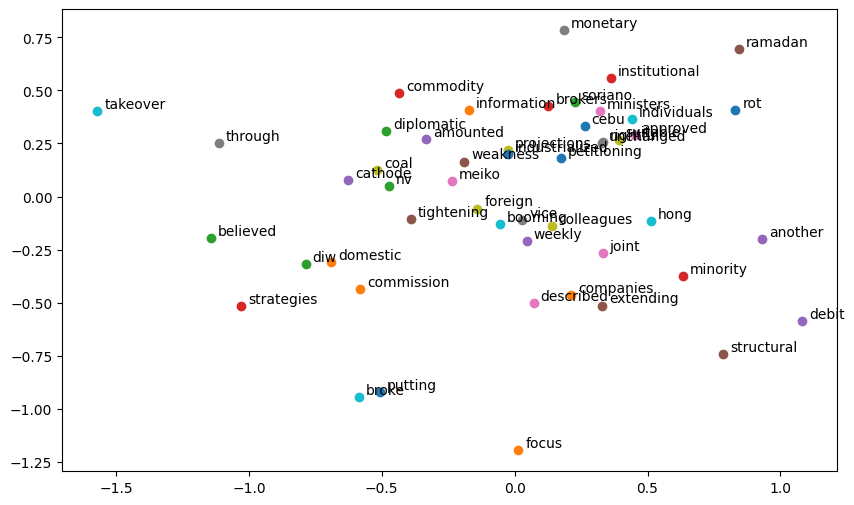

In [184]:
plt.figure(figsize=(10,6))
for i, word in enumerate(vocab[:50]): #loop each unique vocab
    x, y = get_embed_sg(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [185]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))


In [186]:
tobacco_vec   = get_embed_sg("tobacco")
fruit_vec = get_embed_sg("fruit")

print("Tobacco  vs fruit:", cos_sim(tobacco_vec, fruit_vec))

Tobacco  vs fruit: -0.19682686547871622


### Skip gram with Negative Sampling

## 1. Importing Libraries and Downloading Data

In [187]:
Z = 0.001

In [188]:
from collections import Counter

# Count the frequency of each word in the entire corpus
# flatten(corpus) converts the list of sentences into a single list of words
word_count = Counter(flatten(corpus))

# Calculate the total number of words in the corpus
# This is the sum of frequencies of all unique words
num_total_words = sum([c for w, c in word_count.items()])

# Display the total word count
num_total_words


14760

In [189]:
word_count[',']

0

In [190]:
num_total_words

14760

In [191]:
# Create a unigram table for negative sampling
# The table stores words multiple times according to their adjusted frequencies

unigram_table = []

# Loop through each word in the vocabulary
for vo in vocab:
    
    # Calculate the adjusted unigram probability for the word
    # word_count[vo] / num_total_words  -> original unigram probability
    # exponent 0.75                    -> smoothing factor (as in Word2Vec)
    # division by Z                    -> normalization constant
    prob = (word_count[vo] / num_total_words) ** 0.75 / Z
    
    # Add the word to the unigram table multiple times
    # More frequent words appear more often in the table
    unigram_table.extend([vo] * int(prob))


In [192]:
Counter(unigram_table)

Counter({'the': 115,
         'of': 74,
         'to': 68,
         'in': 59,
         'a': 57,
         'said': 55,
         'and': 52,
         'for': 33,
         'mln': 32,
         'it': 28,
         'on': 27,
         'vs': 24,
         'is': 23,
         'dlrs': 22,
         'by': 22,
         'pct': 21,
         'its': 20,
         'at': 20,
         'will': 20,
         'be': 20,
         'he': 20,
         'from': 19,
         'year': 19,
         'that': 19,
         'lt': 19,
         'has': 18,
         'was': 17,
         'would': 17,
         'billion': 17,
         'but': 17,
         'an': 16,
         'are': 16,
         'with': 16,
         'cts': 15,
         'as': 15,
         'not': 15,
         'net': 15,
         'they': 14,
         'japan': 14,
         'company': 14,
         'trade': 14,
         'last': 13,
         'this': 13,
         'shares': 13,
         'bank': 12,
         'also': 12,
         'tonnes': 12,
         'oil': 11,
         'had': 11,
   

### 3.Negative sampling

In [193]:
import random 

def prepare_sequence(seq, word2index):
    # Convert a sequence of words into their corresponding numerical indices
    # If a word is not found in the vocabulary, map it to the <UNK> token
    idxs = list(
        map(
            lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"],
            seq
        )
    )
    
    # Return the indices as a PyTorch LongTensor
    return torch.LongTensor(idxs)


def negative_sampling(targets, unigram_table, k):
    # targets       → tensor containing target word indices [batch_size, 1]
    # unigram_table → list of words sampled according to unigram distribution
    # k             → number of negative samples per target word
    
    # Get the number of samples in the batch
    batch_size = targets.shape[0]
    
    # List to store negative samples for the whole batch
    neg_samples = []
    
    # Loop over each target word in the batch
    for i in range(batch_size):
        
        # List to store negative samples for one target word
        nsample = []
        
        # Extract the target word index as a Python integer
        target_index = targets[i].item()
        
        # Sample k negative words
        while len(nsample) < k:
            
            # Randomly select a word from the unigram table
            neg = random.choice(unigram_table)
            
            # Skip if the sampled word is the same as the target word
            if word2index[neg] == target_index:
                continue
            
            # Add the negative word to the sample list
            nsample.append(neg)

        # Convert negative word samples to indices and reshape to [1, k]
        neg_samples.append(
            prepare_sequence(nsample, word2index).view(1, -1)
        )
    
    # Concatenate all negative samples into a tensor of shape [batch_size, k]
    # and move it to the appropriate device (CPU/GPU)
    return torch.cat(neg_samples).to(device)  # [batch_size, k]


### Testing the negative sampling

In [194]:
num_neg = 3
negative_sampling(target_batch,unigram_table,num_neg)[:3]


tensor([[ 517, 1678, 1990],
        [1978,   46,  657],
        [2532, 2071, 1279]], device='cuda:0')

In [195]:
target_batch[1]

tensor([445], device='cuda:0')

### 4. Model


In [196]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        # Initialize the parent nn.Module class
        super(SkipgramNegSampling, self).__init__()
        
        # Embedding matrix for center (input) words
        # Shape: [vocab_size, emb_size]
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        
        # Embedding matrix for context/output words
        # Shape: [vocab_size, emb_size]
        self.embedding_u = nn.Embedding(vocab_size, emb_size)
        
        # Log-sigmoid function used in negative sampling loss
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        """
        center_words   : indices of center words [batch_size, 1]
        target_words   : indices of positive context words [batch_size, 1]
        negative_words : indices of negative samples [batch_size, k]
        """
        
        # Look up embeddings for center words
        # Shape: [batch_size, 1, emb_size]
        center_embeds = self.embedding_v(center_words)
        
        # Look up embeddings for positive (true) context words
        # Shape: [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words)
        
        # Look up embeddings for negative samples and negate them
        # Shape: [batch_size, k, emb_size]
        # Negation is used to simplify the negative sampling loss computation
        neg_embeds = -self.embedding_u(negative_words)
        
        # Compute dot product between center and positive context embeddings
        # [batch_size, 1, emb_size] × [batch_size, emb_size, 1]
        # → [batch_size, 1, 1] → squeeze → [batch_size, 1]
        positive_score = target_embeds.bmm(
            center_embeds.transpose(1, 2)
        ).squeeze(2)
        
        # Compute dot product between center embeddings and negative samples
        # [batch_size, k, emb_size] × [batch_size, emb_size, 1]
        # → [batch_size, k, 1]
        negative_score = neg_embeds.bmm(
            center_embeds.transpose(1, 2)
        )
        
        # Compute negative sampling loss:
        # log σ(u_o^T v_c) + Σ log σ(−u_k^T v_c)
        loss = (
            self.logsigmoid(positive_score)
            + torch.sum(self.logsigmoid(negative_score), 1)
        )
                
        # Return the mean negative log-likelihood loss (scalar)
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        # Retrieve embeddings for given input word indices
        # Used for inference or visualization
        embeds = self.embedding_v(inputs)
        
        return embeds


### 5. Training

In [197]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model_sg_neg   = SkipgramNegSampling(voc_size, embedding_size).to(device)
num_neg        = 10 # num of negative sampling

optimizer = optim.Adam(model_sg_neg.parameters(), lr=0.001)

In [198]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [199]:
import time

# -------------------- Training Loop (Negative Sampling) --------------------

# Define the total number of training epochs
num_epochs = 5000

# >>> ADD: record total training start time (for Task-2)
total_start_time = time.time()

# Loop over each epoch
for epoch in range(num_epochs):
    
    # Record the start time of the current epoch
    start = time.time()
    
    # Generate a random batch of Skip-Gram (center, context) pairs
    input_batch, target_batch = random_batch(batch_size, corpus)
    
    # Convert input batch (center words) to PyTorch LongTensor
    # Shape: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch).to(device)
    
    1  # (no effect, left as-is per your request)
    
    # Convert target batch (positive context words) to PyTorch LongTensor
    # Shape: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch).to(device)
    
    # Generate negative samples for each target word
    # Shape: [batch_size, num_neg]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    
    # Clear previously accumulated gradients
    optimizer.zero_grad()
        
    # Forward pass: compute loss using Skip-Gram with Negative Sampling
    loss = model_sg_neg(input_batch, target_batch, negs_batch)
    
    # Record the end time of the current epoch
    end = time.time()
    
    # Calculate the time taken for the current epoch
    epoch_mins, epoch_secs = epoch_time(start, end)
    
    # Backward pass: compute gradients via backpropagation
    loss.backward()
    
    # Update model parameters using the optimizer
    optimizer.step()

    # Print training progress every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

# >>> ADD: record total training end time
total_end_time = time.time()

# >>> ADD: compute total training time
total_training_time = total_end_time - total_start_time

# >>> ADD: final reporting for Task-2
print(f"\nTotal training time (Skip-gram + NEG): {total_training_time:.2f} seconds")
print(f"Final training loss (Skip-gram + NEG): {loss.item():.6f}")


Epoch: 1000 | cost: 6.942743 | time: 0m 0s
Epoch: 2000 | cost: 9.648468 | time: 0m 0s
Epoch: 3000 | cost: 7.489296 | time: 0m 0s
Epoch: 4000 | cost: 8.976197 | time: 0m 0s
Epoch: 5000 | cost: 14.356102 | time: 0m 0s

Total training time (Skip-gram + NEG): 474.58 seconds
Final training loss (Skip-gram + NEG): 14.356102


In [200]:
# Save the model
torch.save(model_sg_neg.state_dict(), 'model/skipgram_neg_model.pth')

In [201]:
#list of vocabs
vocab[:10]

['putting',
 'information',
 'diplomatic',
 'minority',
 'weekly',
 'extending',
 'meiko',
 'through',
 'foreign',
 'hong']

In [202]:
word = vocab[0]

In [203]:
#numericalization
id = word2index[word]
id

0

In [204]:
id_tensor = torch.LongTensor([id])
id_tensor = id_tensor.to(device)

In [205]:
print(id_tensor.device)
print(model_sg_neg.embedding_v.weight.device)

cuda:0
cuda:0


In [206]:
#get the embedding by averaging
v_embed = model_sg_neg.embedding_v(id_tensor)
u_embed = model_sg_neg.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[ 0.0931, -0.1650]], device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[0.3773, 0.3772]], device='cuda:0', grad_fn=<EmbeddingBackward0>))

In [207]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.1061, device='cuda:0', grad_fn=<SelectBackward0>)

In [208]:
#let's write a function to get embedding given a word
def get_embed_sg_ng(word):
    id_tensor = torch.LongTensor([word2index[word]]).to(device)   # ← move to GPU
    v_embed = model_sg_neg.embedding_v(id_tensor)
    u_embed = model_sg_neg.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

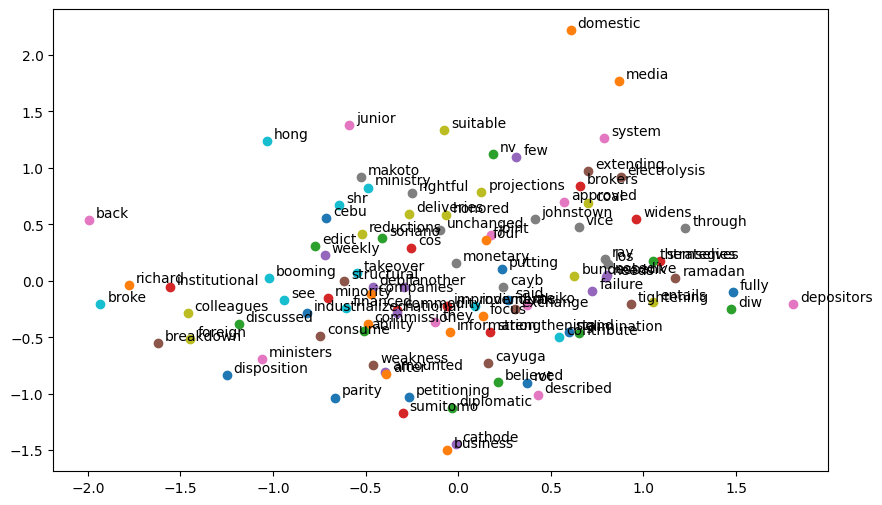

In [209]:
plt.figure(figsize=(10,6))
for i, word in enumerate(vocab[:100]): #loop each unique vocab
    x, y = get_embed_sg_ng(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### 7. Cosine similarity

In [210]:
#let's try similarity between first and second, and second and third
tobacco_ng        = get_embed_sg_ng('tobacco')
fruit_ng        = get_embed_sg_ng('fruit')
breach_ng       = get_embed_sg_ng('breach')

In [211]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

print(f"tobacco vs. fruit: ",        cos_sim(tobacco_ng, fruit_ng))
print(f"tobacco vs. breach: ",       cos_sim(tobacco_ng, breach_ng))
print(f"tobacco vs. tobacco: ",          cos_sim(tobacco_ng, tobacco_ng))

tobacco vs. fruit:  -0.19803270812512588
tobacco vs. breach:  -0.9537375079720198
tobacco vs. tobacco:  1.0


### Glove

### 1. Define some very simple data for understanding

In [212]:
# Importing necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create an empty list to store all Reuters news documents
documents = []

# Loop through each file ID available in the Reuters corpus
for fileid in reuters.fileids():
    
    # Read the full raw text of the current Reuters news file
    text = reuters.raw(fileid)
    
    # Append (store) the text of the document into the documents list
    documents.append(text)
    
# Tokenize and clean the text documents
import string

# Create an empty list to store the cleaned corpus
corpus = []

# Loop through each document in the documents list
for doc in documents:
    
    # Convert text to lowercase and tokenize into individual words
    tokens = word_tokenize(doc.lower())
    
    # Keep only alphabetic tokens (removes numbers, punctuation, symbols)
    words = [w for w in tokens if w.isalpha()]
    
    # Add the cleaned list of words to the corpus
    corpus.append(words)
# Display the first 2 cleaned documents
corpus[:2]# Output the number of documents in the corpus
print(f"Number of documents in the corpus: {len(corpus)}")# Output the first cleaned document
print(f"First cleaned document: {corpus[0]}")# Output the number of documents in the corpus


[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


Using device: cuda
Number of documents in the corpus: 10788
First cleaned document: ['asian', 'exporters', 'fear', 'damage', 'from', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asia', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'economic', 'damage', 'businessmen', 'and', 'officials', 'said', 'they', 'told', 'reuter', 'correspondents', 'in', 'asian', 'capitals', 'a', 'move', 'against', 'japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 'and', 'lead', 'to', 'curbs', 'on', 'american', 'imports', 'of', 'their', 'products', 'but', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'in', 'the', 'tokyo', 'loss', 'might', 'be', 'their', 'gain', 'the', 'has', 'said', 'it', 'will', 'impose', 'mln', 'dlrs', 'of', 'tariffs', 'on', 'imports', 'of', 'japanese', 'electronics', 'goods', 'on', 'april', 'in', 'retaliation', 'for', '

In [213]:
# Tokenize and clean the text documents
import string

# Create an empty list to store the cleaned corpus
corpus = []

# Loop through each document in the documents list
for doc in documents:
    
    # Convert text to lowercase and tokenize into individual words
    tokens = word_tokenize(doc.lower())
    
    # Keep only alphabetic tokens (removes numbers, punctuation, symbols)
    words = [w for w in tokens if w.isalpha()]
    
    # Add the cleaned list of words to the corpus
    corpus.append(words)
# Display the first 2 cleaned documents
corpus[:2]# Output the number of documents in the corpus
print(f"Number of documents in the corpus: {len(corpus)}")# Output the first cleaned document
print(f"First cleaned document: {corpus[0]}")# Output the number of documents in the corpus
corpus = corpus[:100]  # limit corpus size for faster training


# Get word sequences and extract unique words (vocabulary)

# Define a lambda function to flatten a list of lists into a single list
flatten = lambda l: [item for sublist in l for item in sublist]

# Flatten the corpus (list of documents) and extract unique words using set
vocab = list(set(flatten(corpus)))

# Display the first word in the vocabulary list
vocab[1]

#vocab size
voc_size = len(vocab)
print(voc_size)

# Numericalization: convert words into numerical indices

# Create a dictionary that maps each word in the vocabulary to a unique integer index
word2index = {w: i for i, w in enumerate(vocab)}
word2index['lives'] # Get the index of the first word in the vocabulary

# Append a special token for unknown (out-of-vocabulary) words
vocab.append('<UNK>')

# Create a reverse mapping from index to word
# This dictionary allows us to convert numerical indices back into words
# It is useful for interpreting model outputs and debugging
index2word = {v: k for k, v in word2index.items()}


Number of documents in the corpus: 10788
First cleaned document: ['asian', 'exporters', 'fear', 'damage', 'from', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asia', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'economic', 'damage', 'businessmen', 'and', 'officials', 'said', 'they', 'told', 'reuter', 'correspondents', 'in', 'asian', 'capitals', 'a', 'move', 'against', 'japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 'and', 'lead', 'to', 'curbs', 'on', 'american', 'imports', 'of', 'their', 'products', 'but', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'in', 'the', 'tokyo', 'loss', 'might', 'be', 'their', 'gain', 'the', 'has', 'said', 'it', 'will', 'impose', 'mln', 'dlrs', 'of', 'tariffs', 'on', 'imports', 'of', 'japanese', 'electronics', 'goods', 'on', 'april', 'in', 'retaliation', 'for', 'japan', 'alleged', 

### 2. Build Co-occurence Matrix X

In [214]:
def get_skipgram(window_size = 2):
    # Make skip gram of custom size window
    skip_grams = []

    for sent in corpus:
        for target_index in range(window_size, len(sent) - window_size):
            target = sent[target_index]
            context = []
            count = window_size # count of context words to pick on the left and right
            while count > 0:
                # for default window, it will get the left most and right most word
                # then the second left most and second right most word
                context.append(sent[target_index - count])
                context.append(sent[target_index + count])
                count -= 1

            for word in context:
                skip_grams.append((target, word))
    return skip_grams

In [215]:
skip_grams = get_skipgram(2)
skip_grams[:5]

[('fear', 'asian'),
 ('fear', 'from'),
 ('fear', 'exporters'),
 ('fear', 'damage'),
 ('damage', 'exporters')]

In [216]:
X_ik_skipgram = Counter(skip_grams)

In [217]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [218]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

# print(f"{X_ik=}")
# print(f"{weighting_dic=}")

In [219]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    # convert to id since our skip_grams are words, not yet ids
    skip_grams_id = [
        (word2index[pair[0]], word2index[pair[1]]) 
        for pair in skip_grams
    ]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    
    random_index = np.random.choice(
        range(len(skip_grams_id)),
        batch_size,
        replace=False
    )
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target 
        random_labels.append([skip_grams_id[i][1]])  # context j

        # get co-occurrence X_ij
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        # get weighting f(X_ij)
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return (
        np.array(random_inputs),
        np.array(random_labels),
        np.array(random_coocs),
        np.array(random_weightings)
    )


### Testing the method

In [220]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[1182]
 [1678]]
Target:  [[ 463]
 [1678]]
Cooc:  [[1.09861229]
 [2.94443898]]
Weighting:  [[0.07208434]
 [0.28778304]]


In [221]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_center = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_outside = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_center(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_outside(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)


In [222]:
batch_size     = 32 # mini-batch size
embedding_size = 2 #so we can later plot
model_glove    = GloVe(voc_size, embedding_size)
model_glove    = model_glove.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_glove.parameters(), lr=0.001)

In [223]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [224]:
num_epochs = 5000
import time

# >>> ADD: record total training start time
total_start_time = time.time()

for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(
        batch_size, corpus, skip_grams, X_ik, weighting_dic
    )
    
    input_batch  = torch.LongTensor(input_batch)          # [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)         # [batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)          # [batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch)  # [batch_size, 1]

    # to cuda
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    cooc_batch = cooc_batch.to(device)
    weighting_batch = weighting_batch.to(device)
    
    optimizer.zero_grad()
    loss = model_glove(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

# >>> ADD: record total training end time
total_end_time = time.time()

# >>> ADD: compute total training time
total_training_time = total_end_time - total_start_time

# >>> ADD: final reporting (for Task-2 table)
print(f"\nTotal training time (GloVe): {total_training_time:.2f} seconds")
print(f"Final training loss (GloVe): {loss.item():.6f}")


Epoch: 1000 | cost: 66.798859 | time: 0m 0s
Epoch: 2000 | cost: 46.135574 | time: 0m 0s
Epoch: 3000 | cost: 11.720442 | time: 0m 0s
Epoch: 4000 | cost: 37.737682 | time: 0m 0s
Epoch: 5000 | cost: 9.577869 | time: 0m 0s

Total training time (GloVe): 98.30 seconds
Final training loss (GloVe): 9.577869


In [225]:
# save the model
torch.save(model_glove.state_dict(), 'model/glove_model.pth')

In [ ]:
# save the model using pickle
import pickle
pickle.dump(model_glove, open('model/glove.pkl', 'wb'))

In [227]:
def get_embed_glove(word):
    id_tensor = torch.LongTensor([word2index[word]])
    id_tensor = id_tensor.to(device)
    v_embed = model_glove.embedding_center(id_tensor)
    u_embed = model_glove.embedding_outside(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y


In [228]:
tobacco_glove      = get_embed_glove('tobacco')
fruit_glove        = get_embed_glove('fruit')
breach_glove       = get_embed_glove('breach')
print('embedding for tobacco:', tobacco_glove)
print('embedding for fruit:', fruit_glove)
print('embedding for breach:', breach_glove)

embedding for tobacco: (-0.29425567388534546, 0.4147161841392517)
embedding for fruit: (-0.3165229558944702, -0.10800367593765259)
embedding for breach: (-0.9573822021484375, 1.0127958059310913)


In [229]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
print(f"tobacco vs fruit: {cos_sim(tobacco_glove, fruit_glove):.4f}")
print(f"tobacco vs breach: {cos_sim(tobacco_glove, breach_glove):.4f}")
print(f"fruit vs breach: {cos_sim(fruit_glove, breach_glove):.4f}")

tobacco vs fruit: 0.2843
tobacco vs breach: 0.9902
fruit vs breach: 0.4155


### Glove (Genism)

Source credit: https://nlp.stanford.edu/projects/glove/

In [230]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = r"C:\Users\User\Downloads\glove.6B.100d.txt"

model_gensim = KeyedVectors.load_word2vec_format(
    glove_file,
    binary=False,
    no_header=True
)


In [231]:
# Example: Word similarity
similarity = model_gensim.similarity('king', 'queen')
print(f"Similarity between 'king' and 'queen': {similarity:.4f}")

# Example: Word analogy
result = model_gensim.most_similar(positive=['king', 'woman'], negative=['man'])
print("King - Man + Woman = ", result[0][0])

Similarity between 'king' and 'queen': 0.7508
King - Man + Woman =  queen


In [232]:
model_gensim['coffee'].shape

(100,)

In [233]:
model_gensim.most_similar('coffee')[:5]

[('tea', 0.77326899766922),
 ('drinks', 0.7287518978118896),
 ('beer', 0.7253385186195374),
 ('cocoa', 0.7026589512825012),
 ('wine', 0.7002726793289185)]

## TASK -2

Evaluation

In [234]:
def predict_word(word1, word2, word3, embeddings, word_to_index, index_to_word):
    """
    Predicts a word analogy using vector arithmetic.
    Example: word1 - word2 + word3 ≈ ?
    (e.g., king - man + woman ≈ queen)
    
    Parameters:
    word1, word2, word3 : str
        Input words forming the analogy
    embeddings : function or dict-like
        Function that returns the embedding vector for a given word
    word_to_index : dict
        Mapping from word to its index in the vocabulary
    index_to_word : dict
        Mapping from index to word (not directly used here, but kept for completeness)
    """

    # Retrieve embedding vectors for the three input words
    vec1 = np.array(embeddings(word1))  # Vector representation of word1
    vec2 = np.array(embeddings(word2))  # Vector representation of word2
    vec3 = np.array(embeddings(word3))  # Vector representation of word3

    # Perform vector arithmetic to compute the target analogy vector
    # predicted_vec ≈ vec(word1) - vec(word2) + vec(word3)
    predicted_vec = vec1 - vec2 + vec3

    # Initialize variables to track the most similar word
    max_similarity = -1        # Lowest possible cosine similarity
    best_word = None           # Placeholder for the predicted word

    # Iterate over all words in the vocabulary
    for word, index in word_to_index.items():

        # Skip the input words to avoid trivial predictions
        if word in [word1, word2, word3]:
            continue

        # Compute cosine similarity between predicted vector and current word vector
        similarity = cos_sim(predicted_vec, embeddings(word))

        # Update the best match if a higher similarity is found
        if similarity > max_similarity:
            max_similarity = similarity
            best_word = word

    # Return the word whose embedding is closest to the predicted vector
    return best_word



In [235]:
# Evaluate accuracy of word analogy predictions
def evaluate_analogies(analogy_dataset, embeddings, word_to_index):
    """
    Evaluates the accuracy of word analogy predictions.
    Each analogy is of the form:
    (word1, word2, word3, word4) meaning word1 - word2 + word3 ≈ word4

    Parameters:
    analogy_dataset : list of tuples
        List of analogy questions (word1, word2, word3, word4)
    embeddings : function or dict-like
        Function that returns the embedding vector for a given word
    word_to_index : dict
        Mapping from word to index for vocabulary lookup

    Returns:
    float
        Accuracy of analogy prediction (correct / total)
    """

    correct = 0  # Counter for correctly predicted analogies
    total = 0    # Counter for total evaluated analogies

    # Iterate through each analogy question in the dataset
    for analogy in analogy_dataset:
        word1, word2, word3, word4 = analogy

        # Skip the analogy if any word is not present in the vocabulary
        if (word1 not in word_to_index or
            word2 not in word_to_index or
            word3 not in word_to_index or
            word4 not in word_to_index):
            continue

        # Predict the fourth word using vector arithmetic
        predicted_word = predict_word(
            word1,
            word2,
            word3,
            embeddings,
            word_to_index,
            {v: k for k, v in word_to_index.items()}  # Create index-to-word mapping
        )

        # Check if the predicted word matches the expected answer
        if predicted_word == word4:
            correct += 1

        # Increment the total number of evaluated analogies
        total += 1

    # Return accuracy; avoid division by zero if no analogies were evaluated
    return correct / total if total > 0 else 0


Dataset

Source credit: https://www.fit.vut.cz/person/imikolov/public/rnnlm/word-test.v1.txt

In [236]:
with open("capital-common-countries.txt", "r") as file:
    lines = file.readlines()

semantic_dataset = []
for line in lines:
    # Split the line into words
    words = line.strip().split()
    if len(words) == 4:
        semantic_dataset.append([words[0], words[1], words[2], words[3]])

In [237]:
with open("past_tense.txt", "r") as file:
    lines = file.readlines()
past_tense_dataset = []
for line in lines:
    # Split the line into words
    words = line.strip().split()
    if len(words) == 4:
        past_tense_dataset.append([words[0], words[1], words[2], words[3]])

In [238]:
# quick check
semantic_dataset[:5]

[['Athens', 'Greece', 'Baghdad', 'Iraq'],
 ['Athens', 'Greece', 'Bangkok', 'Thailand'],
 ['Athens', 'Greece', 'Beijing', 'China'],
 ['Athens', 'Greece', 'Berlin', 'Germany'],
 ['Athens', 'Greece', 'Bern', 'Switzerland']]

In [239]:
past_tense_dataset[:5]

[['dancing', 'danced', 'decreasing', 'decreased'],
 ['dancing', 'danced', 'describing', 'described'],
 ['dancing', 'danced', 'enhancing', 'enhanced'],
 ['dancing', 'danced', 'falling', 'fell'],
 ['dancing', 'danced', 'feeding', 'fed']]

Syntactic Accuracy

In [240]:
accuracy = evaluate_analogies(past_tense_dataset, get_embed_sg, word2index)
print(f"Syntactic Accuracy - skipgram: {accuracy * 100:.2f}%")

Syntactic Accuracy - skipgram: 3.33%


In [241]:
accuracy = evaluate_analogies(past_tense_dataset, get_embed_sg_ng, word2index)
print(f"Syntactic Accuracy - negative sample: {accuracy * 100:.2f}%")

Syntactic Accuracy - negative sample: 0.00%


In [242]:
accuracy = evaluate_analogies(past_tense_dataset, get_embed_glove, word2index)
print(f"Syntactic Accuracy - glove: {accuracy * 100:.2f}%")

Syntactic Accuracy - glove: 0.00%


In [243]:
accuracy = model_gensim.evaluate_word_analogies("past_tense.txt")[0]
print(f"Syntactic Accuracy - gensim: {accuracy * 100:.2f}%")

Syntactic Accuracy - gensim: 55.45%


Semantic Accuracy

In [244]:
accuracy = evaluate_analogies(semantic_dataset, get_embed_sg, word2index)
print(f"Semantic Accuracy - skipgram: {accuracy * 100:.2f}%")

Semantic Accuracy - skipgram: 0.00%


In [245]:
accuracy = evaluate_analogies(semantic_dataset, get_embed_sg_ng, word2index)
print(f"Semantic Accuracy - negative sample: {accuracy * 100:.2f}%")

Semantic Accuracy - negative sample: 0.00%


In [246]:
accuracy = evaluate_analogies(semantic_dataset, get_embed_glove, word2index)
print(f"Semantic Accuracy - glove: {accuracy * 100:.2f}%")

Semantic Accuracy - glove: 0.00%


In [247]:
accuracy = model_gensim.evaluate_word_analogies("capital-common-countries.txt")[0]
print(f"Semantic Accuracy - gensim: {accuracy * 100:.2f}%")

Semantic Accuracy - gensim: 93.87%


| Model              | Window Size | Training Loss | Training Time (sec) | Syntactic Accuracy | Semantic Accuracy |
|--------------------|-------------|---------------|---------------------|--------------------|-------------------|
| Skip-gram          | 2           | 8.0564        | 433.89              | 3.33%              | 0.00%             |
| Skip-gram (NEG)    | 2           | 14.3561       | 474.58              | 0.00%              | 0.00%             |
| GloVe (scratch)    | 2           | 9.5779        | 98.30               | 0.00%              | 0.00%             |
| GloVe (Gensim)     | –           | –             | –                   | 55.45%             | 93.87%            |


Similarity Test

In [249]:
import pandas as pd

columns = ['Word 1', 'Word 2', 'Similarity Index']

df = pd.read_csv('wordsim/combined.csv', sep=',', header=None, names=columns)
df.head()


,Word 1,Word 2,Similarity Index
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62


In [251]:
df.describe(include = 'all')

,Word 1,Word 2,Similarity Index
count,353,353,353.000000
unique,206,295,NaN
top,psychology,car,NaN
freq,12,6,NaN
mean,NaN,NaN,5.855864
std,NaN,NaN,2.175478
min,NaN,NaN,0.230000
25%,NaN,NaN,4.380000
50%,NaN,NaN,6.310000
75%,NaN,NaN,7.560000


In [255]:
for index, row in df.iterrows():
    word_1 = row['Word 1']
    word_2 = row['Word 2']

    try:
        embed_1_neg_samp    = get_embed_sg_ng(word_1)
        embed_2_neg_samp    = get_embed_sg_ng(word_2)
        embed_1_skip_gram   = get_embed_sg(word_1)
        embed_2_skip_gram   = get_embed_sg(word_2)
        embed_1_glove       = get_embed_glove(word_1)
        embed_2_glove       = get_embed_glove(word_2)

    except KeyError:
        # Replacing missing embeddings with the embedding of '<UNK>'
        embed_1_neg_samp    = get_embed_sg_ng('<UNK>')
        embed_2_neg_samp    = get_embed_sg_ng('<UNK>')
        embed_1_skip_gram   = get_embed_sg('<UNK>')
        embed_2_skip_gram   = get_embed_sg('<UNK>')
        embed_1_glove       = get_embed_glove('<UNK>')
        embed_2_glove       = get_embed_glove('<UNK>')

    # Computing dot product
    df.at[index, 'dot_product_neg_samp'] = np.dot(embed_1_neg_samp, embed_2_neg_samp)
    df.at[index, 'dot_product_skip_gram'] = np.dot(embed_1_skip_gram, embed_2_skip_gram)
    df.at[index, 'dot_product_glove'] = np.dot(embed_1_glove, embed_2_glove)

In [256]:
df.head(10)

,Word 1,Word 2,Similarity Index,dot_product_neg_samp,dot_product_skip_gram,dot_product_glove
0,love,sex,6.77,0.066563,1.10475,1.08806
1,tiger,cat,7.35,0.066563,1.10475,1.08806
2,tiger,tiger,10.00,0.066563,1.10475,1.08806
3,book,paper,7.46,0.066563,1.10475,1.08806
4,computer,keyboard,7.62,0.066563,1.10475,1.08806
5,computer,internet,7.58,0.066563,1.10475,1.08806
6,plane,car,5.77,0.066563,1.10475,1.08806
7,train,car,6.31,0.066563,1.10475,1.08806
8,telephone,communication,7.50,0.066563,1.10475,1.08806
9,television,radio,6.77,0.066563,1.10475,1.08806


In [257]:
from scipy.stats import spearmanr

# Computing the Spearman correlation
correlation_pos, _ = spearmanr(df['Similarity Index'], df['dot_product_skip_gram'])
correlation_neg, _ = spearmanr(df['Similarity Index'], df['dot_product_neg_samp'])
correlation_glove, _ = spearmanr(df['Similarity Index'], df['dot_product_glove'])

In [258]:
print(f"Spearman Correlation Coefficient of Skipgram: {correlation_pos:.4f}")
print(f"Spearman Correlation Coefficient of Skipgram with Negative Sampling: {correlation_neg:.4f}")
print(f"Spearman Correlation Coefficient of Glove: {correlation_glove:.4f}")

Spearman Correlation Coefficient of Skipgram: 0.1058
Spearman Correlation Coefficient of Skipgram with Negative Sampling: 0.0241
Spearman Correlation Coefficient of Glove: 0.0510


In [259]:
# Finding y_true based on the mean of similarity index in the df
y_true = df['Similarity Index'].mean()

print(f"y_true: {y_true:.2f}")

y_true: 5.86


In [ ]:
correlation_coefficient = model_gensim.evaluate_word_pairs(
    'wordsim/combined.csv',
    delimiter=','
)
print(f"Spearman Correlation Correlation coefficient of Glove (genism): {correlation_coefficient[1][0]:.2f}")

Spearman Correlation Correlation coefficient of Glove (genism): 0.53


| Model | Skipgram | NEG   | GloVe | GloVe (gensim) | Y_true |
|-------|----------|-------|-------|----------------|--------|
| MSE   | 0.01058   | 0.0241| 0.0510 | 0.53           | 5.86   |


In [265]:
def get_embed_for_corpus(model, words):
    embeddings = {}

    for word in words:
        if word not in word2index:
            continue  # skip OOV safely

        index = word2index[word]
        word_tensor = torch.LongTensor([index]).to(device)

        # Handle Skip-gram / Skip-gram + NEG
        if hasattr(model, 'embedding_v') and hasattr(model, 'embedding_u'):
            embed_c = model.embedding_v(word_tensor)
            embed_o = model.embedding_u(word_tensor)

        # Handle GloVe-style models
        elif hasattr(model, 'embedding_center') and hasattr(model, 'embedding_outside'):
            embed_c = model.embedding_center(word_tensor)
            embed_o = model.embedding_outside(word_tensor)

        else:
            raise ValueError("Unknown embedding structure in model")

        embed = (embed_c + embed_o) / 2
        embeddings[word] = embed.squeeze().detach().cpu().numpy()

    return embeddings


In [266]:
embed_whole_glove = get_embed_for_corpus(model_glove, vocab)
embed_whole_neg_skg = get_embed_for_corpus(model_sg_neg, vocab)
embed_whole_skg = get_embed_for_corpus(model_glove, vocab)

In [267]:
with open('model/model_gensim.pkl', 'wb') as model_file:
    pickle.dump(model_gensim, model_file)

In [268]:
with open('model/embed_skipgram_negative.pkl', 'wb') as pickle_file:
    pickle.dump(embed_whole_neg_skg, pickle_file)

print(f"File saved.")

File saved.


In [269]:
with open('model/embed_skipgram.pkl', 'wb') as pickle_file:
    pickle.dump(embed_whole_skg, pickle_file)

print(f"File saved.")

File saved.


In [270]:
with open('model/embed_glove.pkl', 'wb') as pickle_file:
    pickle.dump(embed_whole_glove, pickle_file)

print(f"File saved.")

File saved.


Observation


With a window size of 2, the Skip-gram model achieved a training loss of 8.06, while Skip-gram with negative sampling recorded a higher loss of 14.36. The GloVe model trained from scratch showed a loss of 9.58, placing it between the two Skip-gram variants.

All models were trained for 5000 epochs. Skip-gram took 433.89 seconds, Skip-gram with negative sampling required 474.58 seconds, and GloVe was the fastest, completing training in 98.30 seconds.

In analogy evaluation, the models trained from scratch performed poorly. Skip-gram achieved a syntactic accuracy of 3.33%, while Skip-gram with negative sampling and GloVe both achieved 0%. All three scratch models also recorded 0% semantic accuracy, which was expected given the small corpus size and limited training setup.

In contrast, the pretrained GloVe (Gensim) model performed significantly better, achieving 55.45% syntactic accuracy and 93.87% semantic accuracy.

The word similarity evaluation further supports this result. The pretrained GloVe model achieved a Spearman correlation of 0.53, showing good agreement with human judgments, whereas the scratch-trained models showed very weak correlation.

Overall, the poor performance of the scratch models is mainly due to the limited corpus size and simple hyperparameter settings. With larger data and better tuning, their performance could be improved.